In [1]:
# this first two lines are for deactivating the GPU usage
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"
#----------------------------------------
import numpy as np
import time

We'll work with the Reuters dataset, which is a set of short newswires and their topics, published by Reuters in 1986. There are 46 topics.  

We load the data and select a dictionary of the 10000 most frequently used words. 

In [2]:
from keras.datasets import reuters

(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

2113536/2110848 [==============================] - 1s 1us/step


In [3]:
len(train_data)

8982

In [4]:
train_data.shape

(8982,)

In [7]:
len(train_data[1])

56

In [8]:
len(test_data)

2246

In [9]:
# We can decode the data back to words using the provided dictionary and indices
word_index = reuters.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
decoded_newswire = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]])

557056/550378 [==============================] - 1s 1us/step


In [15]:
decoded_newswire

'? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3'

In [10]:
train_labels[1]

4

### Preparing the data

We can vectorize the data, transforming each sample into a 10000-dimensional vector with 1s and 0s, depending on the appearance of the words in each sample. 

In [16]:
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

In [17]:
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

For the labels we will use one-hot encoding, which transform each label into a vector of 0s, with a 1 in the place of the label index.

In [18]:
def to_one_hot(labels, dimension=46):
    results = np.zeros((len(labels), dimension))
    for i, label in enumerate(labels):
        results[i, label] = 1.
    return results

In [19]:
one_hot_train_labels = to_one_hot(train_labels)
one_hot_test_labels = to_one_hot(test_labels)

### Building the network  
As this is a multiclass classification problem, we need to have a number of output units equal to the number of classes (categories) of our problem. In this case this is 46.   
In the same way, the number of units in the hidden layer has to be in accordance to the output number. If we use 16 units, we would be limiting the information to too few units, acting as a bottleneck and we would be dropping relevant information. Thus, we use 64 units in the hidden layers. 

In [20]:
from keras import models, layers

In [21]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000, )))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

We end the model with 46 units, meaning we'll be outputing a 46-dimensional vector, equal to the number of categories we want to classify our dataset. We also use a `softmax` activations function in the output layer, which will give us a probability distribution over the 46 output units, all of which will sum 1. 

Now we compile the model, selecting the metrics:

In [22]:
model.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

To validate our data while we are training it, we take some amount out of the training data and create a validation set. 

In [24]:
x_val = x_train[:1000]
partial_x_train = x_train[1000:]

y_val = one_hot_train_labels[:1000]
partial_y_train = one_hot_train_labels[1000:]

We train the neural network, selecting the epochs, in this case we put 20. 

In [25]:
history = model.fit(partial_x_train, partial_y_train, epochs=20, batch_size=512, validation_data=(x_val, y_val))

Train on 7982 samples, validate on 1000 samples
Epoch 1/20
7982/7982 [==============================] - 3s 373us/step - loss: 2.5322 - acc: 0.4955 - val_loss: 1.7208 - val_acc: 0.6120
Epoch 2/20
7982/7982 [==============================] - 2s 226us/step - loss: 1.4452 - acc: 0.6879 - val_loss: 1.3459 - val_acc: 0.7060
Epoch 3/20
7982/7982 [==============================] - 2s 226us/step - loss: 1.0953 - acc: 0.7651 - val_loss: 1.1708 - val_acc: 0.7430
Epoch 4/20
7982/7982 [==============================] - 2s 223us/step - loss: 0.8697 - acc: 0.8165 - val_loss: 1.0793 - val_acc: 0.7590
Epoch 5/20
7982/7982 [==============================] - 2s 226us/step - loss: 0.7034 - acc: 0.8472 - val_loss: 0.9844 - val_acc: 0.7810
Epoch 6/20
7982/7982 [==============================] - 2s 225us/step - loss: 0.5667 - acc: 0.8802 - val_loss: 0.9411 - val_acc: 0.8040
Epoch 7/20
7982/7982 [==============================] - 2s 222us/step - loss: 0.4581 - acc: 0.9048 - val_loss: 0.9083 - val_acc: 0.8020


We plot the loss and accuracy curves:

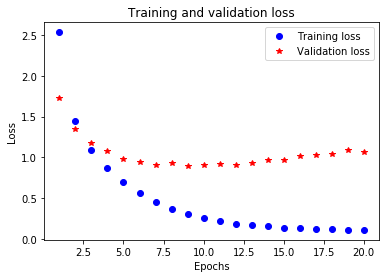

In [28]:
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r*', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

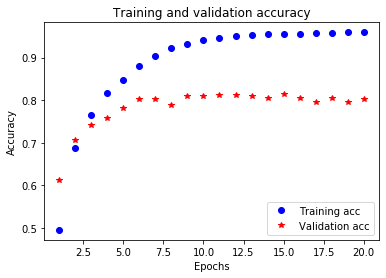

In [30]:
plt.clf()
acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r*', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

We can see that from epoch 9, the loss function for the validation set starts to increase again. We can train the whole model again, until epoch 9 and evaluate it on the validation data.

In [31]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(partial_x_train, 
          partial_y_train, 
          epochs=9, 
          batch_size=512, 
          validation_data=(x_val, y_val))
results = model.evaluate(x_test, one_hot_test_labels)
results

Train on 7982 samples, validate on 1000 samples
Epoch 1/9
7982/7982 [==============================] - 2s 264us/step - loss: 2.5398 - acc: 0.5226 - val_loss: 1.6733 - val_acc: 0.6570
Epoch 2/9
7982/7982 [==============================] - 2s 210us/step - loss: 1.3712 - acc: 0.7121 - val_loss: 1.2758 - val_acc: 0.7210
Epoch 3/9
7982/7982 [==============================] - 2s 204us/step - loss: 1.0136 - acc: 0.7781 - val_loss: 1.1303 - val_acc: 0.7530
Epoch 4/9
7982/7982 [==============================] - 2s 203us/step - loss: 0.7976 - acc: 0.8251 - val_loss: 1.0539 - val_acc: 0.7590
Epoch 5/9
7982/7982 [==============================] - 2s 205us/step - loss: 0.6393 - acc: 0.8624 - val_loss: 0.9754 - val_acc: 0.7920
Epoch 6/9
7982/7982 [==============================] - 2s 205us/step - loss: 0.5124 - acc: 0.8923 - val_loss: 0.9102 - val_acc: 0.8140
Epoch 7/9
7982/7982 [==============================] - 2s 204us/step - loss: 0.4123 - acc: 0.9137 - val_loss: 0.8932 - val_acc: 0.8210
Epoch 8

[1.022207977935234, 0.7756010686194165]

We reached an accuracy of ~78%.  
To predict with the model on new data, we use the method `predict`, 

In [32]:
predictions = model.predict(x_test)

In [34]:
# the shape of the prediction is equal to the output units of our output layer
predictions[0].shape

(46,)

In [39]:
# the sum of the predictions on each category is equal to 1
np.sum(predictions[2])

1.0

In [53]:
# to get the predicted value, we get the class with the highest probability
np.argmax(predictions[9])

3

In [54]:
predictions[9]

array([5.00623582e-06, 3.64852324e-03, 5.08487137e-05, 9.47951972e-01,
       1.94846762e-05, 1.42260046e-06, 7.04497972e-04, 8.80660264e-06,
       1.79429620e-03, 4.65969206e-05, 4.70485465e-05, 1.02367521e-04,
       1.55618889e-02, 4.76600580e-05, 3.20003492e-05, 1.08548345e-04,
       8.42939038e-03, 2.86914110e-05, 1.13492642e-04, 6.74093328e-03,
       7.44927116e-03, 3.08386749e-04, 1.78312446e-04, 1.40956181e-04,
       2.64584873e-04, 3.89729568e-04, 2.18774244e-06, 3.41004670e-05,
       5.34894534e-05, 3.13822420e-05, 1.39895592e-05, 1.02350736e-04,
       6.44944521e-05, 3.95872194e-04, 5.72011504e-06, 1.15952307e-05,
       2.74650776e-03, 6.76502241e-05, 4.10221546e-04, 1.31129986e-04,
       1.32887566e-03, 3.83153529e-04, 8.34987623e-06, 3.98371526e-07,
       3.01551245e-05, 3.62728497e-06], dtype=float32)

To see how the model behaves when the hidden layer has fewer units than the 46 output units, we can train the model again and modify that value. 

In [ ]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(4, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(partial_x_train,
          partial_y_train,
          epochs=20,
          batch_size=128,
          validation_data=(x_val, y_val))


loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r*', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.clf()
acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r*', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()